In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import cv2
from skimage.transform import resize
from skimage.io import imread
from sklearn.utils import shuffle
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam , Adamax, RMSprop
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import glob
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import plot_model




import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CNN

In [4]:
# Generate data paths with labels
train_data_dir = '/content/drive/My Drive/brain_tumor_4class/Training'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
# Generate data paths with labels
train_data_dir = '/content/drive/My Drive/brain_tumor_4class/Testing'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)


In [6]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [7]:
# crobed image size
batch_size = 16
img_size = (128, 128)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5908 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


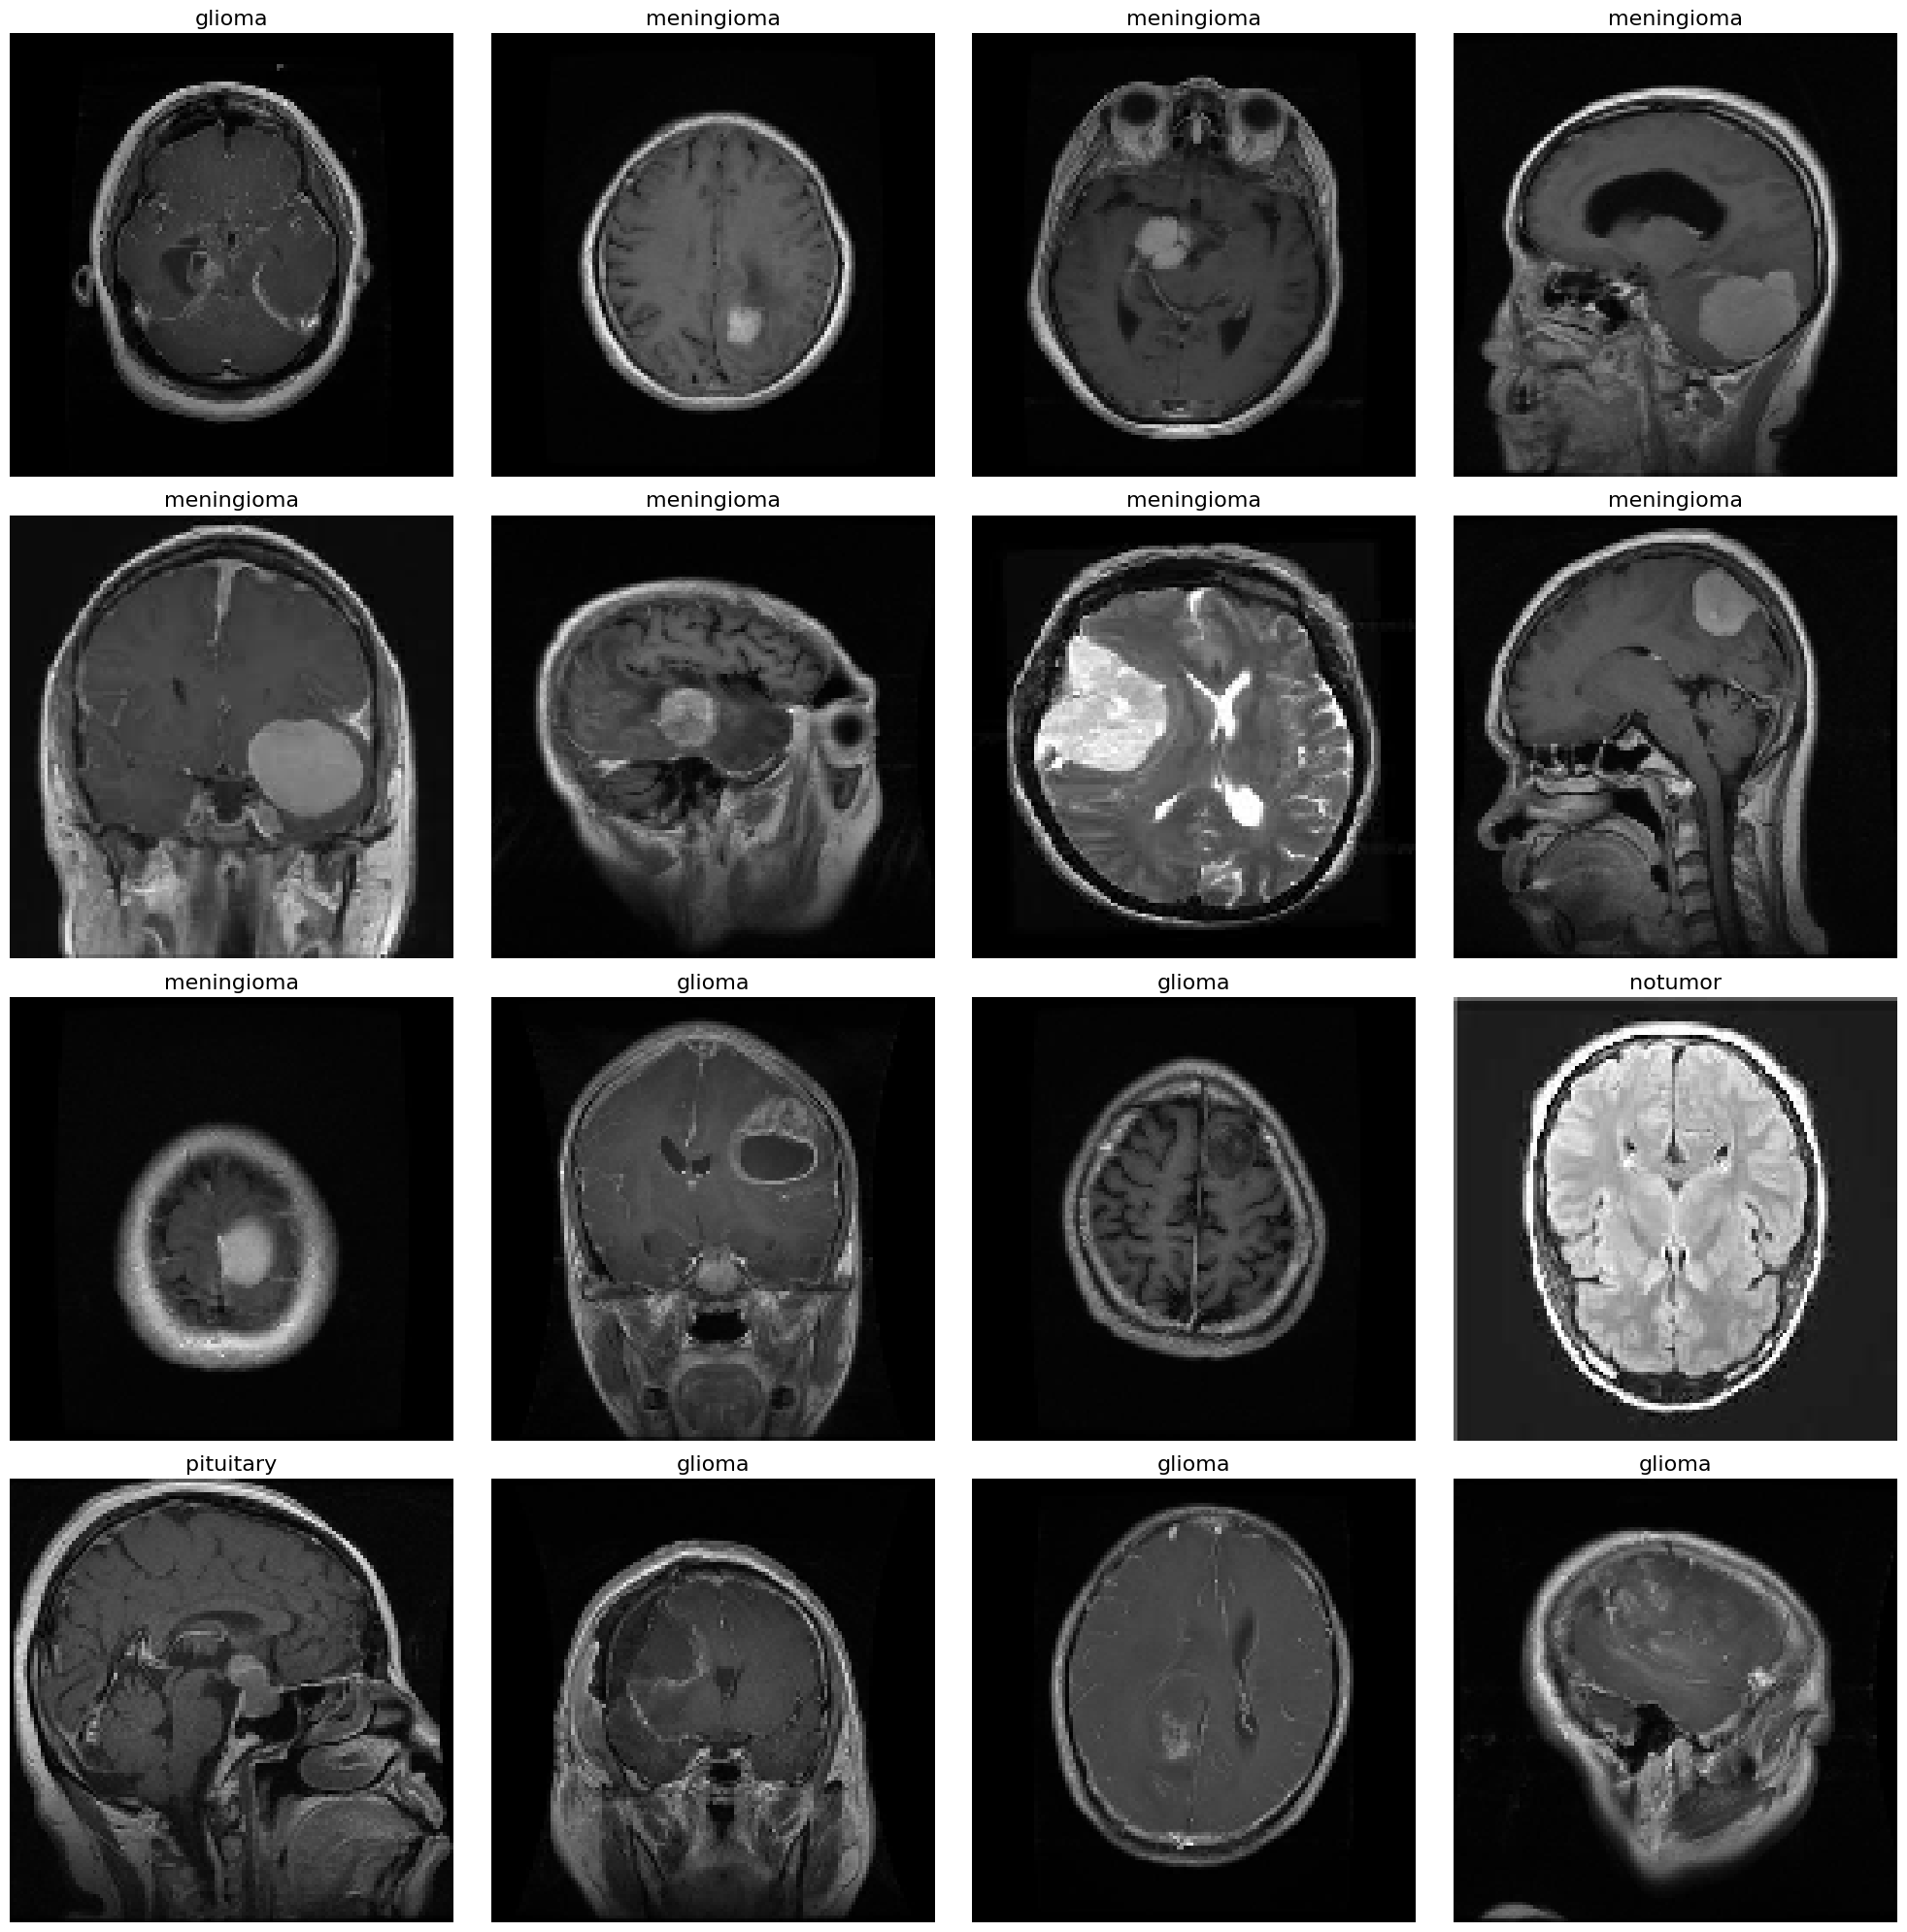

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Model1 2 3by3 conv layer & adamax with 0.001 learning rate

In [11]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= (128,128,3)))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(4, activation = "softmax"))

model.compile(Adamax(learning_rate= 0.001),loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_3 (Dense)             (None, 64)               

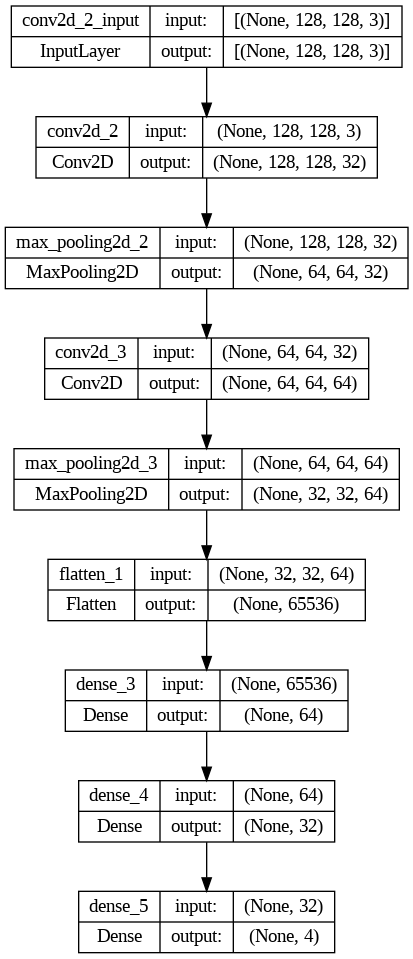

In [12]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

# 51 minute

Epoch 1/10
 13/370 [>.............................] - ETA: 31:11 - loss: 86.7973 - accuracy: 0.3173

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
import itertools

preds = model.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred = np.argmax(preds , axis = 1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

#Model 2 2 3by3 conv layer & Adamax with 0.01 learning rate

In [ ]:
model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= (128,128,3)))
model2.add(MaxPooling2D())

model2.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPooling2D())

model2.add(Flatten())

model2.add(Dense(64,activation = "relu"))
model2.add(Dense(32,activation = "relu"))
model2.add(Dense(4, activation = "softmax"))

model2.compile(Adamax(learning_rate= 0.01),loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

In [ ]:
epochs = 10   # number of all epochs in training

history = model2.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)


In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model2.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model2.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model2.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
import itertools

preds = model2.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred = np.argmax(preds , axis = 1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Model3 2 3by3 conv layer & Adamax with 0.1 learning rate

In [ ]:
model3 = Sequential()

model3.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= (128,128,3)))
model3.add(MaxPooling2D())

model3.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(MaxPooling2D())

model3.add(Flatten())

model3.add(Dense(64,activation = "relu"))
model3.add(Dense(32,activation = "relu"))
model3.add(Dense(4, activation = "softmax"))

model3.compile(RMSprop(learning_rate= 0.1),loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

In [ ]:
epochs = 10   # number of all epochs in training

history = model3.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model3.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model3.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model3.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
import itertools

preds = model3.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred = np.argmax(preds , axis = 1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Model4 2 3by3 conv layer & RMSprop with 0.001 learning rate

In [ ]:
model4 = Sequential()

model4.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= (128,128,3)))
model4.add(MaxPooling2D())

model4.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(MaxPooling2D())

model4.add(Flatten())

model4.add(Dense(64,activation = "relu"))
model4.add(Dense(32,activation = "relu"))
model4.add(Dense(4, activation = "softmax"))

model4.compile(RMSprop(learning_rate= 0.001),loss='categorical_crossentropy', metrics=['accuracy'])

model4.summary()

In [ ]:
epochs = 10   # number of all epochs in training

history = model4.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model4.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model4.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model4.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
import itertools

preds = model4.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred = np.argmax(preds , axis = 1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Model5 2 3by3 conv layer & RMSprop with 0.01 learning rate

In [ ]:
model5 = Sequential()

model5.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= (128,128,3)))
model5.add(MaxPooling2D())

model5.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model5.add(MaxPooling2D())

model5.add(Flatten())

model5.add(Dense(64,activation = "relu"))
model5.add(Dense(32,activation = "relu"))
model5.add(Dense(4, activation = "softmax"))

model5.compile(RMSprop(learning_rate= 0.001),loss='categorical_crossentropy', metrics=['accuracy'])

model5.summary()

In [ ]:
epochs = 10   # number of all epochs in training

history = model5.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model5.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model5.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model5.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
import itertools

preds = model5.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred = np.argmax(preds , axis = 1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Model5 2 3by3 conv layer & RMSprop with 0.1 learning rate

In [ ]:
model6 = Sequential()

model6.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= (128,128,3)))
model6.add(MaxPooling2D())

model6.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model6.add(MaxPooling2D())

model6.add(Flatten())

model6.add(Dense(64,activation = "relu"))
model6.add(Dense(32,activation = "relu"))
model6.add(Dense(4, activation = "softmax"))

model6.compile(RMSprop(learning_rate= 0.001),loss='categorical_crossentropy', metrics=['accuracy'])

model6.summary()

In [ ]:
epochs = 10   # number of all epochs in training

history = model6.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model6.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model6.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model6.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
import itertools

preds = model6.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred = np.argmax(preds , axis = 1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()